# PowerPoint to Knowledge-Grounded & Narrative-Aware Voiceover Transcript Generator

This cookbook demonstrates the complete workflow for converting PowerPoint presentations into AI-generated voiceover transcripts with retrieval augmentation and narrative continuity features, powered by Llama 4 Maverick's vision capabilities through the Llama API.

## Overview

This workflow performs the following operations:

1. **Content Extraction**: Pulls speaker notes and visual elements from PowerPoint slides
2. **Knowledge Base Integration**: Leverages external knowledge sources to enhance transcript quality (For the purposes of this cookbook, the knowledge_base folder)
3. **Image Conversion**: Transforms slides into high-quality images for analysis by Llama 4 Maverick.
4. **Context-Aware Generation**: Creates natural-sounding voiceover content with narrative continuity and knowledge-based insights
    - **Speech Optimization**: Converts numbers, technical terms, and abbreviations to spoken form
6. **Results Export**: Saves transcripts, context information, and knowledge usage statistics in multiple formats

## Key Features

- **Knowledge Base Integration**: Automatically retrieves relevant information from markdown knowledge files
- **Unified Processor**: Single class handles both standard and narrative-aware processing with knowledge enhancement
- **Configurable Context**: Adjustable context window for narrative continuity and knowledge retrieval
- **Mode Selection**: Toggle between standard and narrative processing with optional knowledge integration
- **Performance Optimization**: Caching and lazy loading for efficient knowledge retrieval

## Prerequisites

Before running this notebook, ensure you have:
- Created a `.env` file with your `LLAMA_API_KEY`
- Updated `config.yaml` with your presentation file path
- Set up your knowledge base directory with relevant markdown files (This cookbook only supports markdown format at the moment)
- Enabled knowledge base features in `config.yaml` (set `knowledge.enabled: true`)




## Setup and Configuration

Import required libraries and load environment configuration.

In [50]:
# Import required libraries
import pandas as pd
import os
from pathlib import Path
from dotenv import load_dotenv
import matplotlib.pyplot as plt
from IPython.display import display

In [51]:
# Load environment variables from .env file
load_dotenv()

# Verify setup
if os.getenv('GROQ_API_KEY'):
    print("SUCCESS: Environment loaded successfully!")
    print("SUCCESS: GROQ API key found")
else:
    print("WARNING: GROQ_API_KEY not found in .env file")
    print("Please check your .env file and add your API key")

SUCCESS: Environment loaded successfully!
SUCCESS: GROQ API key found


In [52]:
# Import custom modules
try:
    from src.core.pptx_processor import extract_pptx_notes, pptx_to_images_and_notes
    from src.processors.unified_transcript_generator import (
        UnifiedTranscriptProcessor,
        process_slides,
        process_slides_with_narrative
    )
    from src.config.settings import load_config, get_config, is_knowledge_enabled
    from src.utils.visualization import display_slide_grid, display_slide_preview

    print("SUCCESS: All modules imported successfully!")
    print("- PPTX processor ready")
    print("- Unified transcript generator ready")
    print("- Configuration manager ready")
    print("- Visualization generator ready")

    # Try to import knowledge base modules
    knowledge_available = False
    try:
        from src.knowledge.faiss_knowledge import FAISSKnowledgeManager
        from src.knowledge.context_manager import ContextManager
        knowledge_available = True
        print("- FAISS knowledge base components ready")
    except ImportError as e:
        print(f"- WARNING: Knowledge base components not available: {e}")

except ImportError as e:
    print(f"ERROR: Import error: {e}")
    print("Make sure you're running from the project root directory")

SUCCESS: All modules imported successfully!
- PPTX processor ready
- Unified transcript generator ready
- Configuration manager ready
- Visualization generator ready
- FAISS knowledge base components ready


In [53]:
# Load configuration
config = load_config()
print("\nSUCCESS: Configuration loaded successfully!")
print("\nCurrent Settings:")
print(f"- Llama Model: {config['api']['groq_model']}")
print(f"- Image DPI: {config['processing']['default_dpi']}")
print(f"- Image Format: {config['processing']['default_format']}")
print(f"- Context Window: 5 previous slides (default)")

# Display knowledge base configuration
knowledge_enabled = is_knowledge_enabled()
print(f"- Knowledge Base: {'ENABLED' if knowledge_enabled else 'DISABLED'}")

if knowledge_enabled:
    knowledge_config = config.get('knowledge', {})
    print(f"  - Knowledge Directory: {knowledge_config.get('knowledge_base_dir', 'knowledge_base')}")
    print(f"  - Context Strategy: {knowledge_config.get('context', {}).get('strategy', 'combined')}")
    print(f"  - Knowledge Weight: {knowledge_config.get('context', {}).get('knowledge_weight', 0.3)}")
    print(f"  - Embedding Model: {knowledge_config.get('embedding', {}).get('model_name', 'all-MiniLM-L6-v2')}")


SUCCESS: Configuration loaded successfully!

Current Settings:
- Llama Model: meta-llama/llama-4-maverick-17b-128e-instruct
- Image DPI: 200
- Image Format: png
- Context Window: 5 previous slides (default)
- Knowledge Base: ENABLED
  - Knowledge Directory: knowledge_base
  - Context Strategy: combined
  - Knowledge Weight: 0.3
  - Embedding Model: all-MiniLM-L6-v2


#### Don't forget to update the config file with your pptx file name!


In [54]:
# Configure file paths from config.yaml
pptx_file = config['current_project']['pptx_file'] + config['current_project']['extension']
output_dir = config['current_project']['output_dir']

print("File Configuration:")
print(f"- Input File: {pptx_file}")
print(f"- Output Directory: {output_dir}")

# Verify input file exists
if Path(pptx_file).exists():
    file_size = Path(pptx_file).stat().st_size / 1024 / 1024
    print(f"- SUCCESS: Input file found ({file_size:.1f} MB)")
else:
    print(f"- ERROR: Input file not found: {pptx_file}")
    print("  Please update the 'pptx_file' path in config.yaml")

# Create output directory if needed
Path(output_dir).mkdir(parents=True, exist_ok=True)
print(f"- SUCCESS: Output directory ready")

File Configuration:
- Input File: input/All About Llamas.pptx
- Output Directory: output/
- SUCCESS: Input file found (10.8 MB)
- SUCCESS: Output directory ready


## Knowledge Base Setup and Validation

Set up and validate the knowledge base if enabled in configuration.


In [55]:
def setup_knowledge_base(config):
    """Setup and validate knowledge base if enabled."""
    knowledge_enabled = is_knowledge_enabled()

    if not knowledge_enabled:
        print("Knowledge base is disabled in configuration")
        return None, None

    if not knowledge_available:
        print("WARNING: Knowledge base is enabled but components are not available")
        return None, None

    print("Setting up knowledge base...")

    knowledge_config = config.get('knowledge', {})
    knowledge_base_dir = Path(knowledge_config.get('knowledge_base_dir', 'knowledge_base'))

    # Check if knowledge base directory exists and has content
    if not knowledge_base_dir.exists():
        print(f"Creating knowledge base directory: {knowledge_base_dir}")
        knowledge_base_dir.mkdir(parents=True, exist_ok=True)

        # Create sample knowledge base files for demonstration
        create_sample_knowledge_base(knowledge_base_dir)

    # List existing knowledge files
    md_files = list(knowledge_base_dir.rglob("*.md"))

    print(f"Knowledge Base Status:")
    print(f"- Directory: {knowledge_base_dir}")
    print(f"- Markdown files found: {len(md_files)}")

    if md_files:
        print("- Available knowledge files:")
        for md_file in md_files:
            file_size = md_file.stat().st_size
            print(f"  - {md_file.name} ({file_size} bytes)")
    else:
        print("- No knowledge files found")
        print("- Creating sample knowledge base for demonstration...")
        create_sample_knowledge_base(knowledge_base_dir)
        md_files = list(knowledge_base_dir.rglob("*.md"))
        print(f"- Created {len(md_files)} sample knowledge files")

    # Initialize knowledge manager
    try:
        # Get FAISS configuration from config
        vector_config = knowledge_config.get('vector_store', {})
        embedding_config = knowledge_config.get('embedding', {})

        # Initialize FAISS knowledge manager with configuration
        knowledge_manager = FAISSKnowledgeManager(
            knowledge_base_dir=str(knowledge_base_dir),
            index_type=vector_config.get('index_type', 'flat'),
            embedding_model=embedding_config.get('model_name', 'all-MiniLM-L6-v2'),
            use_gpu=vector_config.get('use_gpu', False)
        )
        knowledge_manager.initialize()

        context_manager = ContextManager()

        # Display knowledge base statistics
        stats = knowledge_manager.get_stats()
        print(f"- Knowledge chunks loaded: {stats['total_chunks']}")
        print(f"- Index type: {stats['index_type']}")
        print(f"- Embedding model: {stats['embedding_model']}")
        print(f"- Model loaded: {stats['model_loaded']}")
        print(f"- Index loaded: {stats['index_loaded']}")

        return knowledge_manager, context_manager

    except Exception as e:
        print(f"ERROR: Failed to initialize knowledge base: {e}")
        import traceback
        traceback.print_exc()
        return None, None


In [56]:
# Setup knowledge base
knowledge_manager, context_manager = setup_knowledge_base(config)

Setting up knowledge base...
Knowledge Base Status:
- Directory: knowledge_base
- Markdown files found: 2
- Available knowledge files:
  - llama diet.md (5762 bytes)
  - llamas.md (7567 bytes)
- Knowledge chunks loaded: 19
- Index type: flat
- Embedding model: all-MiniLM-L6-v2
- Model loaded: True
- Index loaded: True


## Processing Mode Configuration

Choose your processing mode and configure the processor with knowledge integration.


In [57]:
# Configure processing mode with knowledge integration

USE_NARRATIVE = True  # Set to False for standard processing, True for narrative continuity
CONTEXT_WINDOW_SIZE = 5  # Number of previous slides to use as context (only used when USE_NARRATIVE=True)
ENABLE_KNOWLEDGE = True  # Set to False to disable knowledge base integration

print("Processing Mode Configuration:")
if USE_NARRATIVE:
    print(f"- Mode: NARRATIVE CONTINUITY")
    print(f"- Context Window: {CONTEXT_WINDOW_SIZE} previous slides")
else:
    print(f"- Mode: STANDARD PROCESSING")
    print(f"- Features: Independent slide processing, faster execution")

print(f"- Knowledge Integration: {'ENABLED' if ENABLE_KNOWLEDGE else 'DISABLED'}")

if ENABLE_KNOWLEDGE and knowledge_manager:
    print(f"  - Knowledge chunks available: {knowledge_manager.get_stats()['total_chunks']}")
    print(f"  - Search strategy: {config.get('knowledge', {}).get('context', {}).get('strategy', 'combined')}")

# Initialize the unified processor with knowledge integration
processor = UnifiedTranscriptProcessor(
    use_narrative=USE_NARRATIVE,
    context_window_size=CONTEXT_WINDOW_SIZE,
    enable_knowledge=ENABLE_KNOWLEDGE
)

Processing Mode Configuration:
- Mode: NARRATIVE CONTINUITY
- Context Window: 5 previous slides
- Knowledge Integration: ENABLED
  - Knowledge chunks available: 19
  - Search strategy: combined


## Processing Pipeline

Execute the main processing pipeline in three key steps.


### Step 1: Extract Content and Convert to Images

Extract speaker notes and slide text, then convert the presentation to high-quality images for AI analysis.




PROCESSING: Converting PPTX to images and extracting notes...
Processing: All About Llamas.pptx
Extracting speaker notes...
Found notes on 10 of 10 slides
Notes df saved to: /Users/yucedincer/Desktop/Projects/llama-cookbook/end-to-end-use-cases/powerpoint-to-voiceover-transcript/output/All About Llamas_notes.csv
Converting to PDF...


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Converting to PNG images at 200 DPI...

Successfully processed 10 slides
Images saved to: /Users/yucedincer/Desktop/Projects/llama-cookbook/end-to-end-use-cases/powerpoint-to-voiceover-transcript/output

SUCCESS: Processing completed successfully!
- Processed 10 slides
- Images saved to: /Users/yucedincer/Desktop/Projects/llama-cookbook/end-to-end-use-cases/powerpoint-to-voiceover-transcript/output
- Found notes on 10 slides
- DataFrame shape: (10, 8)

Sample Data (First 5 slides):


,slide_number,slide_title,has_notes,notes_word_count,slide_text_word_count
0,1,Llamas: Fascinating Animals of the Andes,True,34,14
1,2,Introduction to Llamas,True,28,25
2,3,Physical Characteristics,True,28,33
3,4,Diet & Habitat,True,24,23
4,5,Behavior & Social Structure,True,31,30



Displaying first 6 of 10 slide images:


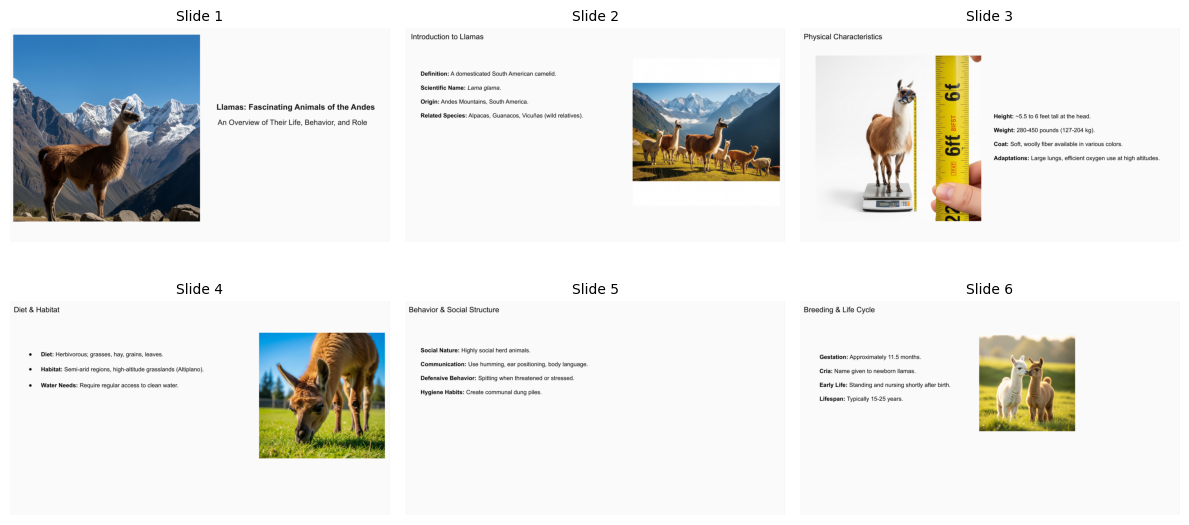

In [58]:
print("PROCESSING: Converting PPTX to images and extracting notes...")

result = pptx_to_images_and_notes(
    pptx_path=pptx_file,
    output_dir=output_dir,
    extract_notes=True
)

notes_df = result['notes_df']
image_files = result['image_files']

print(f"\nSUCCESS: Processing completed successfully!")
print(f"- Processed {len(image_files)} slides")
print(f"- Images saved to: {result['output_dir']}")
print(f"- Found notes on {notes_df['has_notes'].sum()} slides")
print(f"- DataFrame shape: {notes_df.shape}")

# Show sample data
print("\nSample Data (First 5 slides):")
display(notes_df[['slide_number', 'slide_title', 'has_notes', 'notes_word_count', 'slide_text_word_count']].head())

# Preview only the first 6 slide images
display_slide_preview(image_files, num_slides=6, max_cols=3)

### Step 2: Generate Knowledge-Enhanced Narrative-Aware AI Transcripts

Use the Llama vision model to analyze each slide image and generate natural-sounding voiceover transcripts with both narrative continuity and knowledge base enhancement.

This enhanced process:
- Analyzes slide visual content using AI vision
- Retrieves relevant information from the knowledge base
- Uses transcripts from previous slides as context
- Combines slide content, speaker notes, and knowledge insights
- Generates speech-optimized transcripts with smooth transitions and enhanced accuracy
- Maintains consistent terminology throughout the presentation
- Converts numbers and technical terms to spoken form



In [59]:
print("PROCESSING: Starting AI transcript generation with knowledge-enhanced unified processor...")
print(f"- Processing {len(notes_df)} slides")
print(f"- Using model: {config['api']['groq_model']}")
print(f"- Mode: {'Narrative Continuity' if USE_NARRATIVE else 'Standard Processing'}")
print(f"- Knowledge Integration: {'ENABLED' if ENABLE_KNOWLEDGE else 'DISABLED'}")

if USE_NARRATIVE:
    print(f"- Context window: {CONTEXT_WINDOW_SIZE} previous slides")
    print(f"- Using previous transcripts as context for narrative continuity")

if ENABLE_KNOWLEDGE and knowledge_manager:
    print(f"- Knowledge base: {knowledge_manager.get_stats()['total_chunks']} chunks available")
    print(f"- Search strategy: {config.get('knowledge', {}).get('context', {}).get('strategy', 'combined')}")

print("- This may take several minutes...")

# Generate transcripts using the knowledge-enhanced unified processor
processed_df = processor.process_slides_dataframe(
    df=notes_df,
    output_dir=output_dir,
    save_context=True  # Only saves context if USE_NARRATIVE=True
)

print(f"\nSUCCESS: Transcript generation completed!")
print(f"- Generated {len(processed_df)} transcripts")
print(f"- Average length: {processed_df['ai_transcript'].str.len().mean():.0f} characters")
print(f"- Total words: {processed_df['ai_transcript'].str.split().str.len().sum():,}")

if USE_NARRATIVE:
    print(f"- Context information saved to: {output_dir}narrative_context/")
    print(f"- Average context slides used: {processed_df['context_slides_used'].mean():.1f}")

if ENABLE_KNOWLEDGE and knowledge_manager:
    print(f"- Knowledge base integration: Active during processing")
    print(f"- Enhanced transcripts with domain-specific information")

PROCESSING: Starting AI transcript generation with knowledge-enhanced unified processor...
- Processing 10 slides
- Using model: meta-llama/llama-4-maverick-17b-128e-instruct
- Mode: Narrative Continuity
- Knowledge Integration: ENABLED
- Context window: 5 previous slides
- Using previous transcripts as context for narrative continuity
- Knowledge base: 19 chunks available
- Search strategy: combined
- This may take several minutes...
Processing 10 slides with narrative continuity...
Using context window of 5 previous slides


Processing slides: 100%|████████████████████████| 10/10 [00:40<00:00,  4.01s/it]

Context information saved to: output/narrative_context

SUCCESS: Transcript generation completed!
- Generated 10 transcripts
- Average length: 652 characters
- Total words: 951
- Context information saved to: output/narrative_context/
- Average context slides used: 3.5
- Knowledge base integration: Active during processing
- Enhanced transcripts with domain-specific information


In [60]:
# Show first 5 transcripts with detailed knowledge information

from src.utils.transcript_display import show_transcripts_with_knowledge
show_transcripts_with_knowledge(processed_df, knowledge_manager, num_slides=5)



KNOWLEDGE BASE SUMMARY
Total Chunks: 19
Index Type: FLAT
Embedding Model: all-MiniLM-L6-v2
Content Size: 0.0 MB
Avg Chunk Size: 673 characters

Knowledge Sources (2):
  • llama diet.md
  • llamas.md

Knowledge Sections (18):
  • Behavior and Social Structure
  • Conservation Status
  • Diet and Digestion
  • Distribution and Habitat
  • Etymology
  • External Links
  • Llamas vs. Alpacas
  • Physical Description
  • Reproduction and Lifespan
  • Taxonomy
  ... and 8 more
Displaying first 5 slide transcripts with knowledge enhancement


SLIDE 1 - Llamas: Fascinating Animals of the Andes

TRANSCRIPT:
"Llamas are unique animals deeply intertwined with human history and culture in the Andes Mountains of South America. Native to this region, they are primarily found in Peru, Bolivia, Ecuador, Chile, and Argentina. Llamas were domesticated in the Andes around four thousand to five thousand years ago and played a central role in the development of early Andean civilizations, including the In

### Step 3: Save Results

Save results in multiple formats with knowledge integration metadata.


In [61]:
print("PROCESSING: Saving knowledge-enhanced results in multiple formats...")

# Create output directory
os.makedirs(output_dir, exist_ok=True)

# Determine file prefix based on processing mode and knowledge integration
mode_prefix = "narrative" if USE_NARRATIVE else "standard"
knowledge_prefix = "knowledge_enhanced" if ENABLE_KNOWLEDGE else "standard"
file_prefix = f"{knowledge_prefix}_{mode_prefix}"

# Save complete results with all metadata
output_file = f"{output_dir}{file_prefix}_transcripts.csv"
processed_df.to_csv(output_file, index=False)
print(f"- SUCCESS: Complete results saved to {output_file}")

# Save transcript-only version for voiceover work
if USE_NARRATIVE:
    transcript_only = processed_df[['slide_number', 'slide_title', 'ai_transcript', 'context_slides_used']]
else:
    transcript_only = processed_df[['slide_number', 'slide_title', 'ai_transcript']]

transcript_file = f"{output_dir}{file_prefix}_transcripts_clean.csv"
transcript_only.to_csv(transcript_file, index=False)
print(f"- SUCCESS: Clean transcripts saved to {transcript_file}")

# Save as JSON for API integration
json_file = f"{output_dir}{file_prefix}_transcripts.json"
processed_df.to_json(json_file, orient='records', indent=2)
print(f"- SUCCESS: JSON format saved to {json_file}")

# Save knowledge base statistics if available
if ENABLE_KNOWLEDGE and knowledge_manager:
    knowledge_stats_file = f"{output_dir}knowledge_base_stats.json"
    stats = knowledge_manager.get_stats()

    import json
    with open(knowledge_stats_file, 'w') as f:
        json.dump(stats, f, indent=2)
    print(f"- SUCCESS: Knowledge base statistics saved to {knowledge_stats_file}")


PROCESSING: Saving knowledge-enhanced results in multiple formats...
- SUCCESS: Complete results saved to output/knowledge_enhanced_narrative_transcripts.csv
- SUCCESS: Clean transcripts saved to output/knowledge_enhanced_narrative_transcripts_clean.csv
- SUCCESS: JSON format saved to output/knowledge_enhanced_narrative_transcripts.json
- SUCCESS: Knowledge base statistics saved to output/knowledge_base_stats.json


---

# Completion Summary

## Successfully Generated:
- **Knowledge-Enhanced Processing**: Integrated external knowledge base with transcript generation
- **Unified Processing**: Single processor handles standard, narrative, and knowledge-enhanced modes
- **Flexible Configuration**: Easy switching between processing modes and knowledge integration
- **Speech-Optimized Transcripts**: Natural-sounding voiceover content enhanced with domain knowledge
- **Multiple Formats**: CSV, JSON exports for different use cases
- **Context Analysis**: Detailed information about narrative flow and knowledge usage
- **Performance Optimization**: Efficient knowledge retrieval with caching and lazy loading

## Output Files:
- `[knowledge_mode]_[narrative_mode]_transcripts.csv` - Complete dataset with metadata
- `[knowledge_mode]_[narrative_mode]_transcripts_clean.csv` - Clean transcripts for voiceover work
- `[knowledge_mode]_[narrative_mode]_transcripts.json` - JSON format for API integration
- `knowledge_base_stats.json` - Knowledge base usage statistics
- `narrative_context/` - Context analysis files (narrative mode only)
- Individual slide images in PNG/JPEG format

## Processing Modes:

### Standard Mode (`USE_NARRATIVE = False`, `ENABLE_KNOWLEDGE = False`)
- **Best for**: Simple presentations, quick processing, independent slides
- **Features**: Fast execution, no context dependencies
- **Use cases**: Training materials, product demos, standalone slides

### Knowledge-Enhanced Standard Mode (`USE_NARRATIVE = False`, `ENABLE_KNOWLEDGE = True`)
- **Best for**: Technical presentations requiring domain expertise
- **Features**: Domain knowledge integration, improved accuracy
- **Use cases**: Technical documentation, educational materials, expert presentations

### Narrative Mode (`USE_NARRATIVE = True`, `ENABLE_KNOWLEDGE = False`)
- **Best for**: Story-driven presentations, complex topics, educational content
- **Features**: Context awareness, smooth transitions, terminology consistency
- **Use cases**: Conference talks, educational courses, marketing presentations

### Knowledge-Enhanced Narrative Mode (`USE_NARRATIVE = True`, `ENABLE_KNOWLEDGE = True`)
- **Best for**: Complex educational content requiring both continuity and expertise
- **Features**: Full context awareness, domain knowledge, smooth transitions, enhanced accuracy
- **Use cases**: Advanced training, academic presentations, expert-level educational content

## Knowledge Base Features:

### Automatic Knowledge Retrieval
- **Semantic Search**: Uses embedding models to find relevant knowledge chunks
- **Context Integration**: Seamlessly blends knowledge with slide content and speaker notes
- **Fallback Mechanisms**: Graceful degradation if knowledge components fail

### Performance Optimization
- **Caching**: Stores embeddings and search results for faster processing
- **Lazy Loading**: Loads knowledge components only when needed
- **Memory Management**: Efficient memory usage with configurable limits

### Configuration Options
- **Search Strategy**: Choose between knowledge-only, narrative-priority, or combined approaches
- **Knowledge Weight**: Adjust the influence of knowledge base content
- **Similarity Threshold**: Control the relevance threshold for knowledge retrieval

## Next Steps:
1. **Review** generated transcripts for accuracy, flow, and knowledge integration quality
2. **Customize** knowledge base with domain-specific content for your presentations
3. **Tune** knowledge integration parameters for optimal results
4. **Edit** any content that needs refinement
5. **Create** voiceover recordings or use TTS systems
6. **Integrate** JSON data into your video production workflow
7. **Experiment** with different processing modes and knowledge settings

## Tips for Better Results:

### Knowledge Base Optimization
- **Rich Content**: Include comprehensive, well-structured markdown files in your knowledge base
- **Relevant Topics**: Ensure knowledge base content aligns with your presentation topics
- **Clear Structure**: Use proper markdown headers and sections for better chunk extraction
- **Regular Updates**: Keep knowledge base content current and accurate

### Processing Mode Selection
- **Simple Presentations**: Use standard mode for quick, independent slide processing
- **Technical Content**: Enable knowledge integration for domain-specific accuracy
- **Story-Driven Content**: Use narrative mode for presentations with logical flow
- **Complex Educational Material**: Combine both narrative and knowledge features

### Configuration Tuning
- **Context Window**: Adjust context window size (3-7 slides) based on presentation complexity
- **Knowledge Weight**: Fine-tune knowledge influence (0.1-0.5) based on content needs
- **Search Parameters**: Adjust similarity threshold and top-k values for optimal knowledge retrieval
- **Consistent Style**: Maintain consistent formatting across your presentation

### Performance Considerations
- **Memory Usage**: Monitor knowledge base memory consumption for large knowledge bases
- **Processing Time**: Knowledge integration adds processing time but improves quality
- **Caching**: Enable caching for repeated processing of the same presentations
- **Batch Processing**: Process multiple presentations efficiently with shared knowledge base

---

## Advanced Features

### Custom Knowledge Base Creation
Create domain-specific knowledge bases by:
1. **Organizing Content**: Structure markdown files by topic, domain, or presentation type
2. **Using Headers**: Employ clear markdown headers for better chunk extraction
3. **Including Examples**: Add concrete examples and case studies
4. **Maintaining Quality**: Ensure accuracy and relevance of knowledge content

### Integration with Existing Workflows
- **API Integration**: Use JSON output for seamless integration with video production tools
- **Batch Processing**: Process multiple presentations with shared knowledge bases
- **Custom Prompts**: Modify system prompts for specific use cases or audiences
- **Quality Assurance**: Implement review workflows for generated transcripts

### Troubleshooting Common Issues
- **Knowledge Base Not Loading**: Check file paths and permissions
- **Poor Knowledge Retrieval**: Adjust similarity thresholds and search parameters
- **Memory Issues**: Reduce knowledge base size or enable lazy loading
- **Processing Errors**: Enable graceful degradation for robust processing
